In [1]:
import numpy as np
from matplotlib import cm 
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

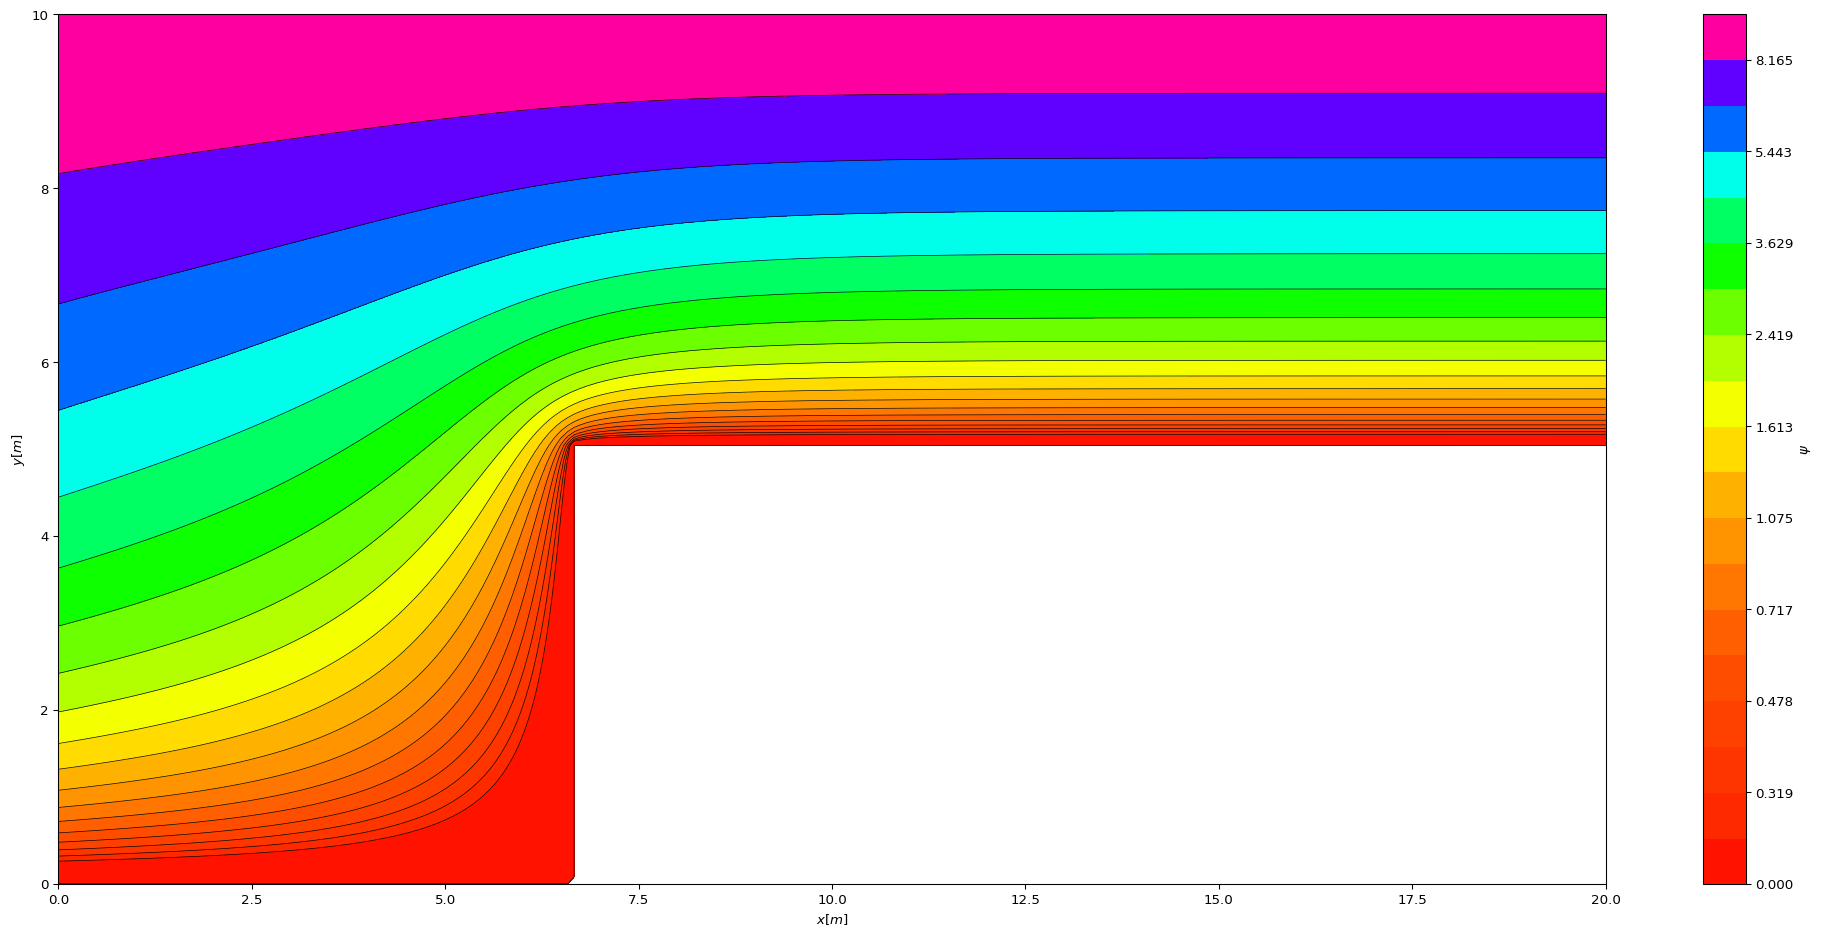

In [2]:
# Dimensões
L = 20 # Comprimento
H = 10 # Altura

# Nós da malha
nx = 256 
ny = 128

# Posição do degrau
Li = 1/3*L
nli = int(nx*Li/L)

# Altura do degrau
Hi = 1/2*H
nhi = int(ny*Hi/H)

# Malha
x, y = np.meshgrid(np.linspace(0,L,nx),np.linspace(0,H,ny))

# Máximo e mínimo
zM = 10.0
zm = 0.0

# Matriz
N = nx*ny
A = lil_matrix((N, N))
A.setdiag( 4.0,  0)
A.setdiag(-1.0, -1)
A.setdiag(-1.0,  1)
A.setdiag(-1.0,-nx)
A.setdiag(-1.0, nx)

# Valores dos cantos
A[0,  0] = 1 # i=0; j=0
A[0,  1] = 0
A[0, nx] = 0

Id = (ny-1)*nx # i=0; j=ny-1
A[Id, Id   ] = 1
A[Id, Id-1 ] = 0
A[Id, Id+1 ] = 0
A[Id, Id-nx] = 0

Id = nx-1 # i=nx-1; j=0
A[Id, Id   ] = 1
A[Id, Id-1 ] = 0
A[Id, Id+1 ] = 0
A[Id, Id+nx] = 0

Id = (ny-1)*nx + (nx-1) # i=nx-1; j=ny-1
A[Id, Id   ] = 1
A[Id, Id-1 ] = 0
A[Id, Id-nx] = 0

# Valores na primeira coluna (i=0)
for j in range(1, ny-1):
    Id = j*nx 
    A[Id,   Id] = 1
    A[Id, Id-1] = 0
    A[Id, Id+1] = 0
    A[Id,Id-nx] = 0
    A[Id,Id+nx] = 0

# Valores na primeira linha (j=ny-1)
for i in range(1, nx-1):
    Id = (ny-1)*nx + i
    A[Id,   Id] = 1
    A[Id, Id+1] = 0
    A[Id, Id-1] = 0
    A[Id,Id-nx] = 0

# Valores na última coluna (i=nx-1)
for j in range(1, ny-1):
    Id = j*nx + (nx-1)
    A[Id, Id   ] = 1
    A[Id, Id-1 ] = 0
    A[Id, Id+1 ] = 0
    A[Id, Id-nx] = 0
    A[Id, Id+nx] = 0

# Valores na última linha (j=0)
for i in range(1, nx-1):
    Id = i
    A[Id, Id] = 1
    A[Id, Id+1] = 0
    A[Id, Id-1] = 0
    A[Id, Id+nx] = 0

for j in range(1,nhi+1):
    for i in range(nli,nx-1):
        Id = j*nx + i
        A[Id, Id   ] = 1
        A[Id, Id-1 ] = 0
        A[Id, Id+1 ] = 0
        A[Id, Id-nx] = 0
        A[Id, Id+nx] = 0

Ve = np.linspace(zm, zM, ny) # Na entrada
Vs = np.linspace(zm, zM, ny-nhi) # Na saída

# Valores colocados no RHS
B = np.zeros(N)
# Valores na primeira coluna (i=0)
for j in range(ny):
    Id = j*nx
    B[Id] = Ve[j]

# Valores na última coluna (i=nx-1)
for j in range(nhi,ny):
    Id = j*nx + (nx-1)
    B[Id] = Vs[j-nhi]

# Valores na primeira linha (j=ny-1)
for i in range(1, nx-1):
    Id = (ny-1)*nx + i
    B[Id] = zM

# Resolvemos o sistema linear de equações
psi = spsolve(A.tocsr(),B)
Psi = psi.reshape([ny,nx])

# Mask various z values.
cm.hot.set_bad('black', alpha=None)
mask = np.zeros_like(Psi, dtype=bool)
mask[:nhi:, nli+1::] = True
z = np.ma.array(Psi, mask=mask)

# Graficamos o resultado
fig, ax = plt.subplots(figsize=(26, 12), dpi=96)
lev_exp = np.arange(zm, zM, 0.5)
lvls=np.power(1/1.5, lev_exp)*zM
lvls[-1] = 0.00000001
cs = ax.contourf(x, y, z, levels=lvls[::-1], corner_mask=False, cmap=cm.hsv)
ax.contour(cs, colors='k', linewidths=0.5)
#ax.grid(c='k', ls='-', alpha=0.3)
cb = fig.colorbar(cs, ax=ax)
cb.set_label("$\psi$")
plt.xlabel('$x[m]$')
plt.ylabel('$y[m]$')
plt.show()